## data preparation

In [28]:
import tensorflow as tf
print(tf.config.list_physical_devices())

import gc
class FreeMemory(tf.keras.callbacks.Callback):
    def __init__(self, log_freq=0):
        super().__init__()
        self.log_freq = log_freq
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.log_freq == 0:
            print(f'epoch {epoch} ended, info: {logs}')
        tf.keras.backend.clear_session()
        gc.collect()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
import numpy as np
raw_data = np.load('/host/dissertation/proccessed_data/x_y_phi_pt_q.npy')
print(raw_data)
event_ids = np.unique(raw_data[:,0]).astype('int32')

[[ 0.00000000e+00 -2.07658215e+01  2.53001633e+01  2.25652742e+00
   6.99481201e+00 -1.00000000e+00]
 [ 0.00000000e+00 -4.30311394e+01  5.22786179e+01  2.25652742e+00
   6.99481201e+00 -1.00000000e+00]
 [ 0.00000000e+00 -4.40572853e+01  5.35139160e+01  2.25652742e+00
   6.99481201e+00 -1.00000000e+00]
 ...
 [ 9.99900000e+03  3.09907928e+02  1.57217087e+02  4.92932558e-01
   4.42384100e+00  1.00000000e+00]
 [ 9.99900000e+03  2.69411377e+02  1.37617249e+02  4.92932558e-01
   4.42384100e+00  1.00000000e+00]
 [ 9.99900000e+03  2.28952026e+02  1.17901054e+02  4.92932558e-01
   4.42384100e+00  1.00000000e+00]]


In [30]:
points_num = 10
new_records = []
for event_id in event_ids:
    particle_data = raw_data[raw_data[:,0] == event_id][:,np.array([False, True, True, True, True, True])]
    # particle_data = raw_data[raw_data[:,0] == event_id][:,np.array([False, True, True, True, True])]
    if len(particle_data) < points_num:
        continue
    order = np.argsort(np.abs(particle_data[:,0] + 1.j * particle_data[:,1]))
    particle_data_sorted = particle_data[order]
    new_record = []
    for point in range(points_num):
        new_record.append(particle_data_sorted[point][0])
        new_record.append(particle_data_sorted[point][1])
    new_record.append(particle_data_sorted[-1][-3])
    new_record.append(particle_data_sorted[-1][-2])
    new_record.append(particle_data_sorted[-1][-1])
    # new_record.append(particle_data_sorted[-1][-2])
    # new_record.append(particle_data_sorted[-1][-1])
    new_records.append(new_record)

print(len(new_records))
new_records

8169


[[-20.76582145690918,
  25.30016326904297,
  -43.0311393737793,
  52.27861785888672,
  -44.05728530883789,
  53.513916015625,
  -73.08868408203125,
  88.435302734375,
  -108.6367416381836,
  130.78538513183594,
  -165.28431701660156,
  197.53672790527344,
  -169.0623321533203,
  201.92532348632807,
  -233.36782836914065,
  276.31903076171875,
  -326.0782775878906,
  381.4654541015625,
  -432.6116027832031,
  499.2059326171875,
  2.2565274238586426,
  6.99481201171875,
  -1.0],
 [11.810263633728027,
  -30.022356033325195,
  24.87393951416016,
  -63.68333053588867,
  41.12107849121094,
  -106.43677520751952,
  91.8692398071289,
  -245.36561584472656,
  123.98650360107422,
  -338.8377685546875,
  166.60215759277344,
  -469.8166809082031,
  212.9799652099609,
  -623.6998901367188,
  255.4525146484375,
  -779.5465698242188,
  256.57098388671875,
  -781.1240234375,
  293.54150390625,
  -945.4650268554688,
  -1.1937464475631714,
  4.118870735168457,
  1.0],
 [-3.6544418334960938,
  31.7463111

In [60]:
np.random.shuffle(new_records)
data_x = []
for record in new_records:
    row = []
    for i in range(0, 2*points_num, 2):
        row.append(record[i] + 1.j * record[i+1])
    data_x.append(row)
data_x =  np.asarray(data_x)

data_y_phi = np.asarray(new_records)[:,-3]
data_y_pt = np.asarray(new_records)[:,-2]
data_y_q = np.asarray(new_records)[:,-1]
data_y_pt_q = data_y_q/data_y_pt

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
def make_dataframe(fit_history):
    df = pd.DataFrame(fit_history.history)
    df['epoch'] = fit_history.epoch
    return df

def plot_loss_history(fit_history, title = "", threshold_multiplier = 10):

    df = make_dataframe(fit_history)

    train_1st_percentile = np.percentile(df['loss'].values, 1)
    val_1st_percentile = np.percentile(df['val_loss'].values, 1)
    print(f'1st percentile of train loss:       {train_1st_percentile:.4e}')
    print(f'1st percentile of validation loss:  {val_1st_percentile:.4e}')
    
    threshold = np.maximum(train_1st_percentile, val_1st_percentile)
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,6))
    axes[0].set_title(f"{title} loss history")
    for axis in axes:
        axis.set_ylim((0, threshold_multiplier*threshold))
        axis.plot(df['epoch'], df['loss'], label='training set')
        axis.plot(df['epoch'], df['val_loss'], linestyle='dashed', label='validation set')
        threshold_multiplier /= 2
    axes[-1].legend(loc="lower left")
    axes[-1].set_xlabel("epoch no.")
    fig.supylabel("loss value")

## $\phi$ regression

In [33]:
import cvnn.layers as complex_layers
from cvnn.losses import ComplexMeanSquareError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import Loss

class AngleError(Loss):
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        return tf.reduce_mean(tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred))))

from tensorflow import Tensor
def activation_phase(z: Tensor) -> Tensor:
        return tf.math.angle(z)

model_phi = tf.keras.models.Sequential()
model_phi.add(complex_layers.ComplexInput(input_shape=(points_num,)))
model_phi.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
model_phi.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
model_phi.add(complex_layers.ComplexDense(units=1, activation=activation_phase))
model_phi.compile(loss=AngleError(), optimizer=SGD(learning_rate=0.01, momentum=0.01))

model_phi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               2816      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 258       
 nse)                                                            
                                                                 
Total params: 36098 (141.01 KB)
Trainable params: 36098 (141.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
history_phi = model_phi.fit(data_x, data_y_phi, shuffle=False, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 0.06699009984731674, 'val_loss': 0.035011425614356995}


KeyboardInterrupt: 

1st percentile of train loss:       8.2570e-03
1st percentile of validation loss:  5.2133e-03


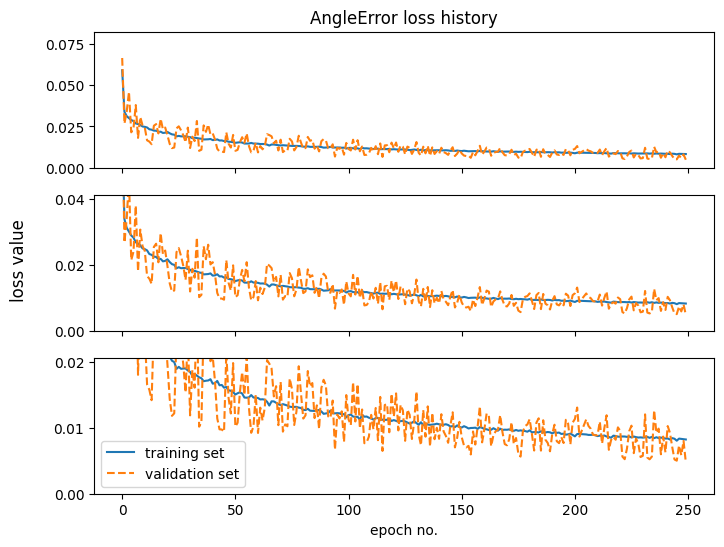

In [ ]:
plot_loss_history(history_phi, "AngleError")

## $pt$ regression

In [104]:
import cvnn.layers as complex_layers
from cvnn.losses import ComplexMeanSquareError
from tensorflow.keras.optimizers import SGD, Adam

model_pt_q = tf.keras.models.Sequential()
model_pt_q.add(complex_layers.ComplexInput(input_shape=(points_num,)))
model_pt_q.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
model_pt_q.add(complex_layers.ComplexDense(units=128, activation='pol_tanh'))
model_pt_q.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_abs'))
model_pt_q.compile(loss='mean_squared_error', optimizer=SGD(clipnorm=1.), metrics=['mean_absolute_percentage_error'])

model_pt_q.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               2816      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 258       
 nse)                                                            
                                                                 
Total params: 36098 (141.01 KB)
Trainable params: 36098 (141.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
history_pt_q = model_pt_q.fit(data_x, data_y_pt, shuffle=False, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 6.967134952545166, 'mean_absolute_percentage_error': 66.83203125, 'val_loss': 6.959771633148193, 'val_mean_absolute_percentage_error': 74.27729797363281}
epoch 10 ended, info: {'loss': 6.766435623168945, 'mean_absolute_percentage_error': 67.3534927368164, 'val_loss': 6.841238021850586, 'val_mean_absolute_percentage_error': 72.54352569580078}
epoch 20 ended, info: {'loss': 6.730519771575928, 'mean_absolute_percentage_error': 67.13468170166016, 'val_loss': 6.840419769287109, 'val_mean_absolute_percentage_error': 72.69864654541016}
epoch 30 ended, info: {'loss': 6.745996475219727, 'mean_absolute_percentage_error': 67.3329849243164, 'val_loss': 6.84862756729126, 'val_mean_absolute_percentage_error': 72.69190216064453}
epoch 40 ended, info: {'loss': 6.663784503936768, 'mean_absolute_percentage_error': 66.79204559326172, 'val_loss': 6.909982204437256, 'val_mean_absolute_percentage_error': 73.97956848144531}
epoch 50 ended, info: {'loss': 5.702519416809082, 'mean

1st percentile of train loss:       2.3115e+00
1st percentile of validation loss:  2.3857e+00


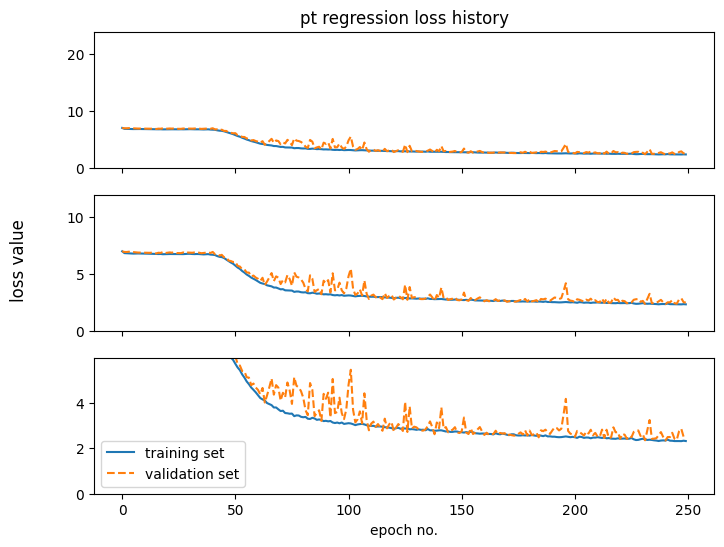

In [108]:
plot_loss_history(history_pt_q, "pt regression")